In [1]:
import os, warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Dropout
from tensorflow.keras.layers import Reshape, Embedding, Flatten, concatenate, multiply
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 32
NUM_CLASSES = 10
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 20000

In [4]:
def load_data():
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = x_train / 127.5 - 1.
    x_train = np.expand_dims(x_train, axis = 3)
    y_train = y_train.reshape(-1, 1)
    return x_train, y_train

In [5]:
x_train, y_train = load_data()
x_train.shape, y_train.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (60000, 1))

In [6]:
def build_generator(latent_dimension, image_shape, num_classes):
    
    model = Sequential([
        Dense(256, input_dim = latent_dimension),
        LeakyReLU(alpha = 0.2),
        BatchNormalization(momentum = 0.8),
        Dense(512),
        LeakyReLU(alpha = 0.2),
        BatchNormalization(momentum = 0.8),
        Dense(1024),
        LeakyReLU(alpha = 0.2),
        BatchNormalization(momentum = 0.8),
        Dense(np.prod(image_shape), activation = 'tanh'),
        Reshape(image_shape)
    ], name = 'Generator_Sequential')
    
    noise = Input(shape = (latent_dimension, ), name = 'Noise_Input')
    label = Input(shape = (1, ), dtype = 'int32', name = 'Label_Input')
    embedding = Embedding(num_classes, latent_dimension, name = 'Embedding')(label)
    label_embedding = Flatten()(embedding)
    
    model_input = multiply([noise, label_embedding])
    image = model(model_input)
    
    return Model([noise, label], image)

In [7]:
def build_discriminator(latent_dimension, image_shape, num_classes):
    
    model = Sequential([
        Dense(512, input_dim = np.prod(image_shape)),
        LeakyReLU(alpha = 0.2),
        Dense(512),
        LeakyReLU(alpha = 0.2),
        Dropout(0.4),
        Dense(512),
        LeakyReLU(alpha = 0.2),
        Dropout(0.4),
        Dense(1, activation = 'sigmoid')
    ], name = 'Discriminator_Sequential')
    
    image = Input(shape = image_shape, name = 'Image_Input')
    label = Input(shape = (1, ), dtype = 'int32', name = 'Label_Input')
    embedding = Embedding(num_classes, np.prod(image_shape), name = 'Embedding')(label)
    label_embedding = Flatten()(embedding)
    
    model_input = multiply([image, label_embedding])
    
    validity = model(model_input)
    
    return Model([image, label], validity)

In [8]:
generator = build_generator(LATENT_DIMENSION, IMAGE_SHAPE, NUM_CLASSES)
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Label_Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1, 100)       1000        Label_Input[0][0]                
__________________________________________________________________________________________________
Noise_Input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           Embedding[0][0]                  
_____________________________________

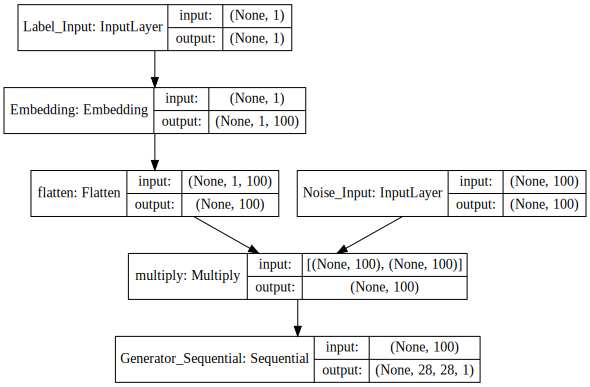

In [9]:
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [10]:
discriminator = build_discriminator(LATENT_DIMENSION, IMAGE_SHAPE, NUM_CLASSES)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Label_Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1, 784)       7840        Label_Input[0][0]                
__________________________________________________________________________________________________
Image_Input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           Embedding[0][0]             

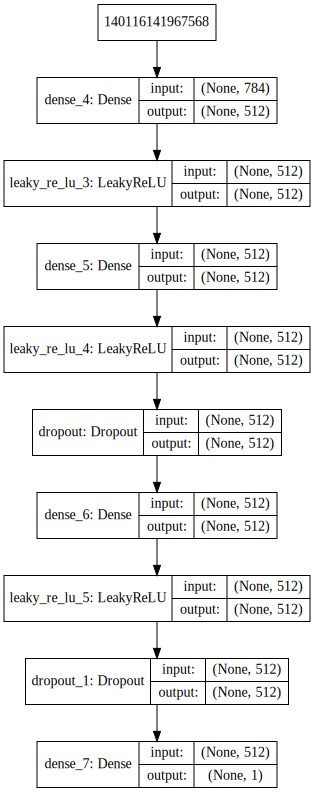

In [11]:
SVG(model_to_dot(discriminator.layers[5], show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
optimizer = Adam(0.0002, 0.5)

In [13]:
discriminator.compile(loss = ['binary_crossentropy'], optimizer = optimizer, metrics = ['accuracy'])

In [14]:
noise = Input(shape = (LATENT_DIMENSION, ))
label = Input(shape = (1, ))
image = generator([noise, label])

In [15]:
discriminator.trainable = False

In [16]:
valid = discriminator([image, label])

In [17]:
gan = Model([noise, label], valid)
gan.compile(loss = ['binary_crossentropy'], optimizer = optimizer)

In [18]:
def train(x_train, y_train, batch_size, epochs):
    generator_loss_history, discriminator_loss_history = [], []
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in tqdm(range(1, epochs + 1)):
        
        # random batch of images
        index = np.random.randint(0, x_train.shape[0], batch_size)
        batch_images, batch_labels = x_train[index], y_train[index]
        
        # Noise for generator input
        noise = np.random.normal(0, 1, (batch_size, 100))
        
        # Generate batch of images from noise
        generated_images = generator.predict([noise, batch_labels])
        
        # Training the Discriminator
        discriminator_loss_real = discriminator.train_on_batch([batch_images, batch_labels], valid)
        discriminator_loss_fake = discriminator.train_on_batch([generated_images, batch_labels], fake)
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        discriminator_loss_history.append(discriminator_loss)
        
        # Label Condition
        sample_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        
        # Training the Generator
        generator_loss = gan.train_on_batch([noise, sample_labels], valid)
        generator_loss_history.append(generator_loss)
        
        if epoch % 500 == 0:
            print('Epoch ' + str(epoch) +\
                  ':\tGenerator Loss = ' + str(generator_loss_history[-1]) +\
                  '\tDiscrimintaor Loss = ' + str(discriminator_loss_history[-1]))
    
    return generator_loss_history, discriminator_loss_history

In [19]:
# generator_loss_history, discriminator_loss_history = train(x_train, y_train, BATCH_SIZE, EPOCHS)